# Lab 2: Cats vs Dogs

**Deadline**: Feb 07, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Saba Ale Ebrahim -- saba.aleebrahim@mail.utoronto.ca

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: 

In [4]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [5]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path, dir):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
        dir: directory location of csvs
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt(dir + "/{}_train_err.csv".format(path))
    val_err = np.loadtxt(dir + "/{}_val_err.csv".format(path))
    train_loss = np.loadtxt(dir + "/{}_train_loss.csv".format(path))
    val_loss = np.loadtxt(dir + "/{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

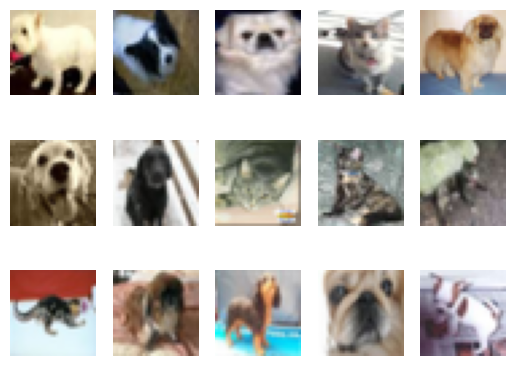

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [5]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8000
2000
2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [7]:
# Validation sets are needed to allow us to tune hyperparameters when training our model. We don't want to use the training set loss/error because it is not representative of model performance as the model
# has already seen this data. This means that the training loss would be an underestimate of the model's true performance, and can lead to overfitting as hyperparameters will be tuned to already seen data

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [6]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [12]:
totalparams_small_net = 0
totalparams_large_net = 0

for param in small_net.parameters():
    totalparams_small_net += torch.numel(param)

for param in large_net.parameters():
    totalparams_large_net += torch.numel(param)

print(totalparams_large_net) # Large network has 9705 parameters, hence why it is large
print(totalparams_small_net) # Small network has 386 parameters, hence why it is small
    

9705
386


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [7]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
#batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [11]:
train_net(small_net)
# Error and loss csvs are created for each epoch. A model checkpoint file is created with the saved values of model weights at each epoch

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.307125, Train loss: 0.5804687016010285 |Validation err: 0.3235, Validation loss: 0.6022688709199429
Epoch 2: Train err: 0.304625, Train loss: 0.5763889074325561 |Validation err: 0.331, Validation loss: 0.6140182111412287
Epoch 3: Train err: 0.301625, Train loss: 0.5750759723186493 |Validation err: 0.322, Validation loss: 0.5886245891451836
Epoch 4: Train err: 0.305125, Train loss: 0.5707294290065765 |Validation err: 0.32, Validation loss: 0.5962079893797636
Epoch 5: Train err: 0.29725, Train loss: 0.5682581138610839 |Validation err: 0.3215, Validation loss: 0.5933639239519835
Finished Training
Total time elapsed: 56.06 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

#from google.colab import drive
#drive.mount('/content/gdrive')

In [13]:
# Train small_net on 30 epochs
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.293625, Train loss: 0.5654548630714417 |Validation err: 0.3215, Validation loss: 0.59278186224401
Epoch 2: Train err: 0.2955, Train loss: 0.5636238236427307 |Validation err: 0.324, Validation loss: 0.6007594745606184
Epoch 3: Train err: 0.2975, Train loss: 0.5639333302974701 |Validation err: 0.315, Validation loss: 0.5824322206899524
Epoch 4: Train err: 0.296375, Train loss: 0.5608411571979522 |Validation err: 0.313, Validation loss: 0.5908570736646652
Epoch 5: Train err: 0.291375, Train loss: 0.5590021996498108 |Validation err: 0.3125, Validation loss: 0.5882907202467322
Epoch 6: Train err: 0.29025, Train loss: 0.5553383073806762 |Validation err: 0.3125, Validation loss: 0.5894749909639359
Epoch 7: Train err: 0.288125, Train loss: 0.5547875807285308 |Validation err: 0.317, Validation loss: 0.582422143779695
Epoch 8: Train err: 0.29175, Train loss: 0.5534406306743622 |Validation err: 0.312

In [14]:
# Train large_net on 30 epochs
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.480875, Train loss: 0.6917510709762573 |Validation err: 0.4555, Validation loss: 0.6884000860154629
Epoch 2: Train err: 0.45225, Train loss: 0.686540602684021 |Validation err: 0.43, Validation loss: 0.684895358979702
Epoch 3: Train err: 0.430375, Train loss: 0.6803846197128296 |Validation err: 0.4005, Validation loss: 0.6737091653048992
Epoch 4: Train err: 0.404875, Train loss: 0.6666054883003235 |Validation err: 0.3735, Validation loss: 0.6509922817349434
Epoch 5: Train err: 0.37275, Train loss: 0.6470689659118652 |Validation err: 0.341, Validation loss: 0.6309727281332016
Epoch 6: Train err: 0.3455, Train loss: 0.6245917983055115 |Validation err: 0.331, Validation loss: 0.6105567663908005
Epoch 7: Train err: 0.331125, Train loss: 0.6131419525146484 |Validation err: 0.3405, Validation loss: 0.6059853825718164
Epoch 8: Train err: 0.330625, Train loss: 0.6082519018650054 |Validation err: 0.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

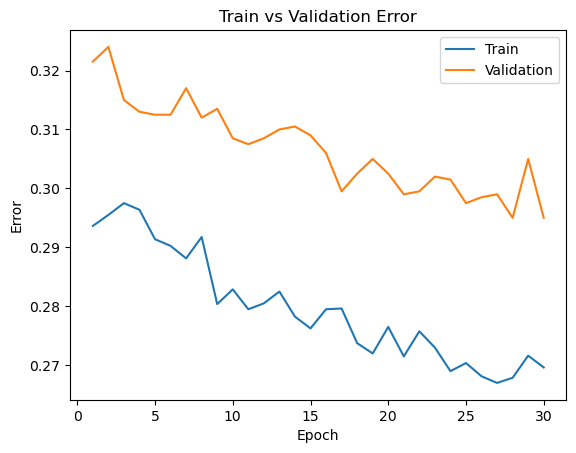

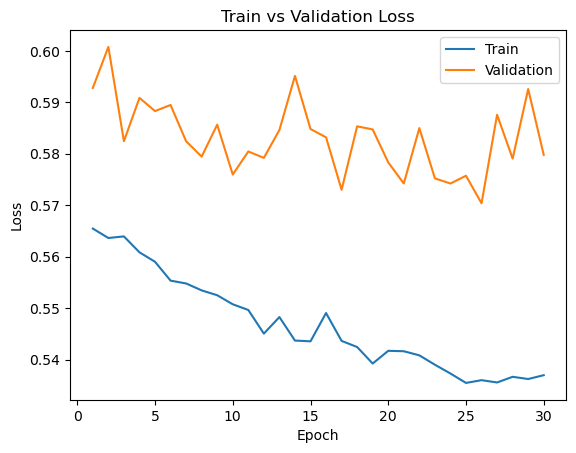

In [16]:
# Produce plots for small net
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
dir = "small_net_Results"
plot_training_curve(model_path, dir)

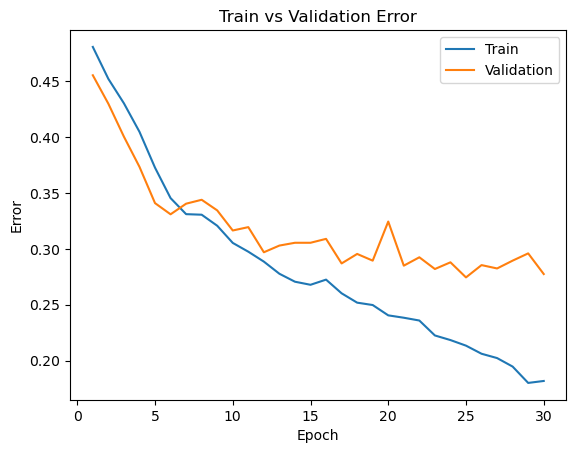

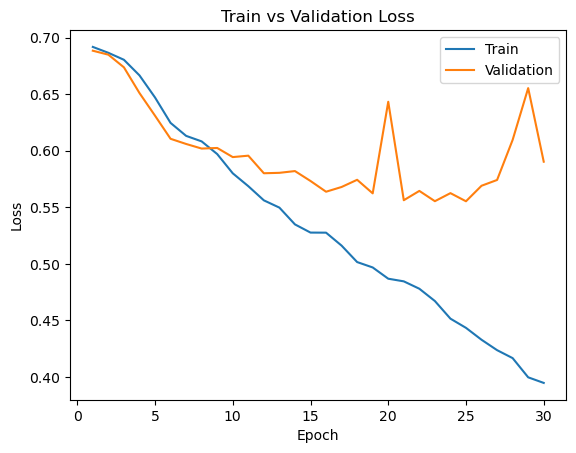

In [17]:
# Produce plots for large net
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
dir = "large_net_Results"
plot_training_curve(model_path, dir)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [18]:
# The large net's validation error and loss converges much more closely to the training loss than that of the small net. While there are still loss differences, the large net experiences less
# overfitting than the small net, which is why we see the validation loss follow more closely to the training loss performance. However, the divergence in loss between the training and validation error
# for both nets demonstrate the effects of overfitting, which would indicate the need for regularization or other overfitting preventative methods.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [19]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, learning_rate=0.001)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.692468661814928
Epoch 2: Train err: 0.448625, Train loss: 0.692258972644806 |Validation err: 0.4305, Validation loss: 0.6916493587195873
Epoch 3: Train err: 0.43575, Train loss: 0.6916067419052124 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.430125, Train loss: 0.6908613085746765 |Validation err: 0.424, Validation loss: 0.6896594054996967
Epoch 5: Train err: 0.43425, Train loss: 0.6899195246696472 |Validation err: 0.4195, Validation loss: 0.6886937450617552
Epoch 6: Train err: 0.435875, Train loss: 0.688741470336914 |Validation err: 0.4195, Validation loss: 0.6867829654365778
Epoch 7: Train err: 0.436875, Train loss: 0.6873777866363525 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.437375, Train loss: 0.685926558971405 |Validation err: 0

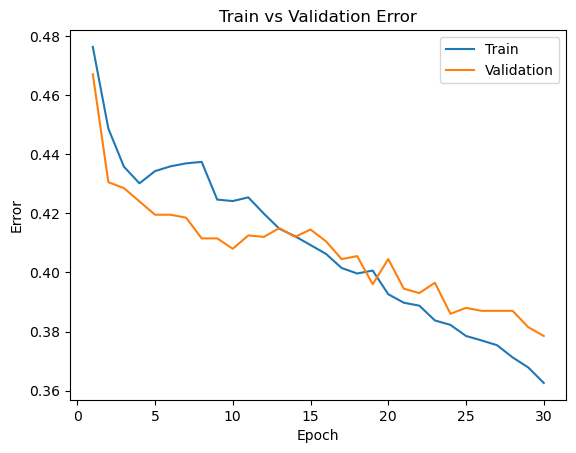

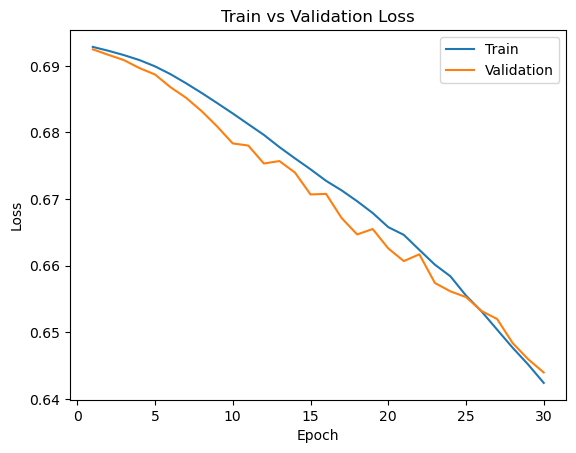

In [20]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
dir = "large_net_Optimize"
plot_training_curve(model_path, dir)

In [ ]:
# Lowering the learning rate decreases the overfitting seen previously with the large net. This also decreased the total training time, which I did not originally expect because the learning rate
# is making the step size for SGD smaller, however, since we have a smaller step size, this enables less error in converging to the minima. Since the overfitting is reduced, we see a larger training error
# but also a larger validation error which coincides more directly with the training results.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [21]:
large_net = LargeNet() # Reinstantiate class to randomize weights
train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.428125, Train loss: 0.6749553589820861 |Validation err: 0.37, Validation loss: 0.6326110046356916
Epoch 2: Train err: 0.35575, Train loss: 0.6302964181900025 |Validation err: 0.414, Validation loss: 0.6971079297363758
Epoch 3: Train err: 0.357875, Train loss: 0.6285605244636535 |Validation err: 0.341, Validation loss: 0.6181797049939632
Epoch 4: Train err: 0.322375, Train loss: 0.6025434257984161 |Validation err: 0.3225, Validation loss: 0.5934312753379345
Epoch 5: Train err: 0.324875, Train loss: 0.5965735516548156 |Validation err: 0.328, Validation loss: 0.5963857378810644
Epoch 6: Train err: 0.307875, Train loss: 0.5746886374950408 |Validation err: 0.3255, Validation loss: 0.6360218031331897
Epoch 7: Train err: 0.2995, Train loss: 0.5706253116130828 |Validation err: 0.328, Validation loss: 0.6113708205521107
Epoch 8: Train err: 0.291, Train loss: 0.5557054822444916 |Validation err: 0.34

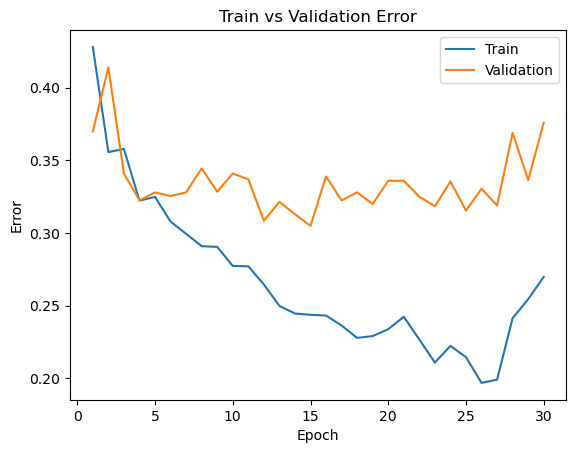

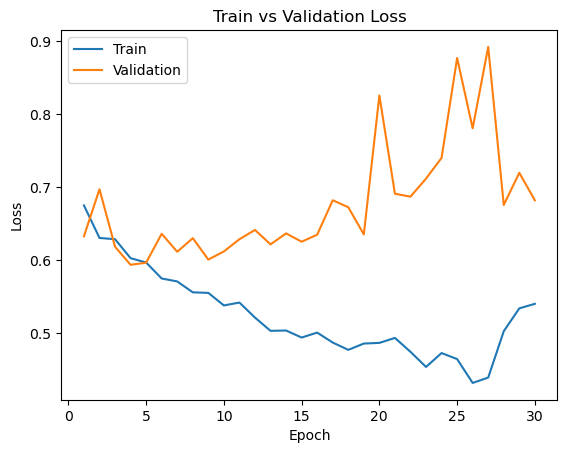

In [22]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
dir = "large_net_Optimize2"
plot_training_curve(model_path, dir)

In [ ]:
# This training run is the longest of the ones done so far. Overfitting is prominient here as the divergence of the training and validation loss is large.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [23]:
large_net = LargeNet() # Reinitialize network class
train_net(large_net, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379478096962 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425394058228
Epoch 3: Train err: 0.437, Train loss: 0.6916500367224216 |Validation err: 0.4265, Validation loss: 0.6909129768610001
Epoch 4: Train err: 0.433625, Train loss: 0.6908450089395046 |Validation err: 0.424, Validation loss: 0.6897871196269989
Epoch 5: Train err: 0.434125, Train loss: 0.6896936297416687 |Validation err: 0.424, Validation loss: 0.6881358921527863
Epoch 6: Train err: 0.43825, Train loss: 0.6883534900844097 |Validation err: 0.428, Validation loss: 0.6860135495662689
Epoch 7: Train err: 0.43925, Train loss: 0.6866876073181629 |Validation err: 0.426, Validation loss: 0.6836975961923599
Epoch 8: Train err: 0.435375, Train loss: 0.6849775537848473 |Validation err: 0.41

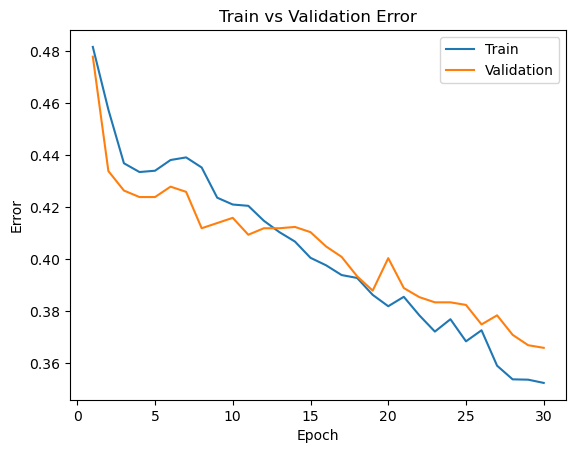

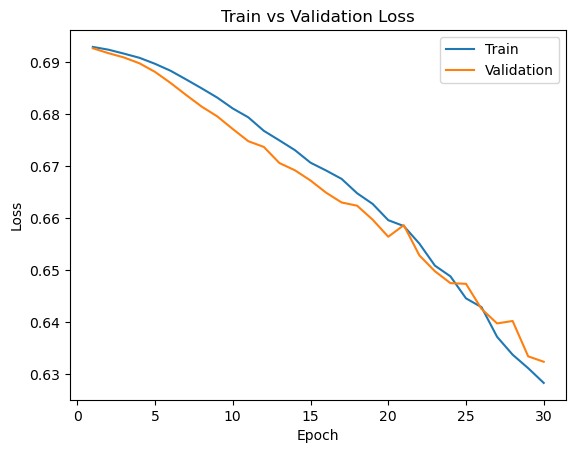

In [27]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
dir = "large_net_Optimize3"
plot_training_curve(model_path, dir)

In [28]:
# The training time was the shortest out of the trials so far. Increasing the batch size decreased overfitting as the training and validation loss does not diverge and is clearly representative
# of one another. However, the loss of the model has now increased from before, representing an underfit of the data. Generally, a smaller batch size allows the network to learn from each input
# individually (making it take longer to train), whereas larger batch sizes decrease that time but may result in the model not learning nuances in the data

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [29]:
large_net = LargeNet()
train_net(large_net, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.431375, Train loss: 0.6774718218445778 |Validation err: 0.378, Validation loss: 0.6522883343696594
Epoch 2: Train err: 0.368125, Train loss: 0.6393496435880661 |Validation err: 0.3535, Validation loss: 0.6192666320800781
Epoch 3: Train err: 0.3385, Train loss: 0.6122594037652016 |Validation err: 0.3455, Validation loss: 0.6485249507427215
Epoch 4: Train err: 0.3155, Train loss: 0.5857512299418449 |Validation err: 0.3445, Validation loss: 0.609103625535965
Epoch 5: Train err: 0.306125, Train loss: 0.5671423997282982 |Validation err: 0.3165, Validation loss: 0.5789317200183869
Epoch 6: Train err: 0.286125, Train loss: 0.547939200758934 |Validation err: 0.305, Validation loss: 0.5776230547428131
Epoch 7: Train err: 0.2705, Train loss: 0.5306402081847191 |Validation err: 0.298, Validation loss: 0.5775952639579773
Epoch 8: Train err: 0.251125, Train loss: 0.5090577985942364 |Validation err: 0.3

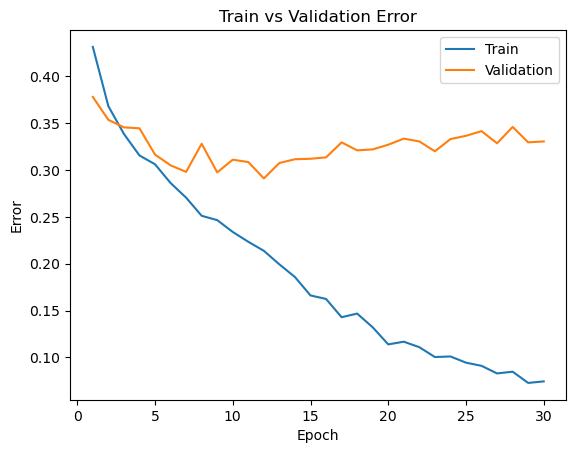

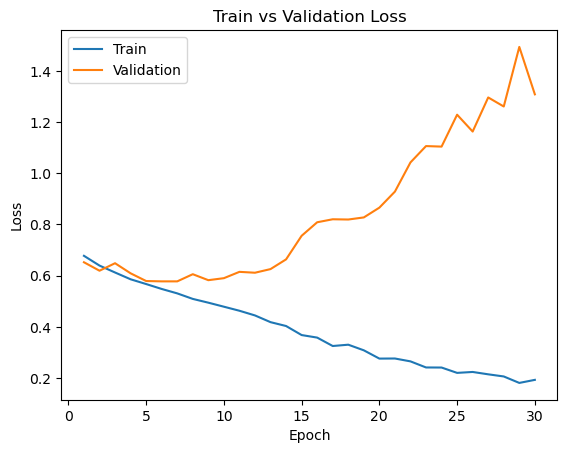

In [30]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
dir = "large_net_Optimize4"
plot_training_curve(model_path, dir)

In [ ]:
# As expected, a smaller batch size allows the model to train on a smaller group of samples at each iteration, thus causing overfitting as the batch size appears to be too small.
# The batch size should be optimized to minimize over/under fitting.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# Batch size = 40
# Learning rate = 0.001 to prevent overfitting from smaller batch size

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [31]:
large_net = LargeNet()
train_net(large_net, batch_size=40, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.469875, Train loss: 0.6926799896359443 |Validation err: 0.438, Validation loss: 0.6920291817188263
Epoch 2: Train err: 0.443, Train loss: 0.6917008408904075 |Validation err: 0.43, Validation loss: 0.690693290233612
Epoch 3: Train err: 0.43475, Train loss: 0.6904439890384674 |Validation err: 0.417, Validation loss: 0.6888978159427643
Epoch 4: Train err: 0.434, Train loss: 0.6886758205294609 |Validation err: 0.4255, Validation loss: 0.6859371602535248
Epoch 5: Train err: 0.43625, Train loss: 0.6864716506004334 |Validation err: 0.413, Validation loss: 0.6830215001106262
Epoch 6: Train err: 0.428625, Train loss: 0.6840072083473205 |Validation err: 0.4105, Validation loss: 0.6800876891613007
Epoch 7: Train err: 0.423125, Train loss: 0.6814907941222191 |Validation err: 0.411, Validation loss: 0.6774645471572875
Epoch 8: Train err: 0.417875, Train loss: 0.6787491607666015 |Validation err: 0.411, 

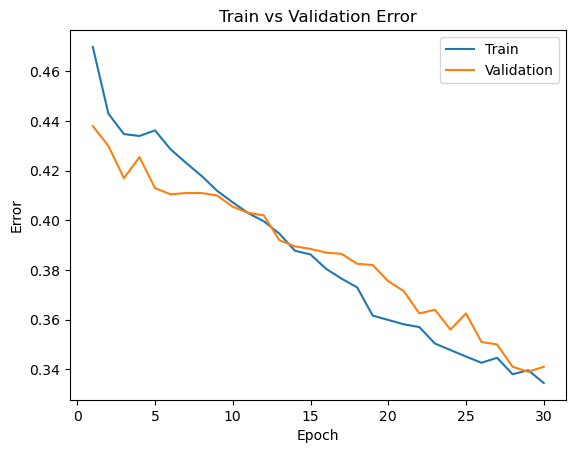

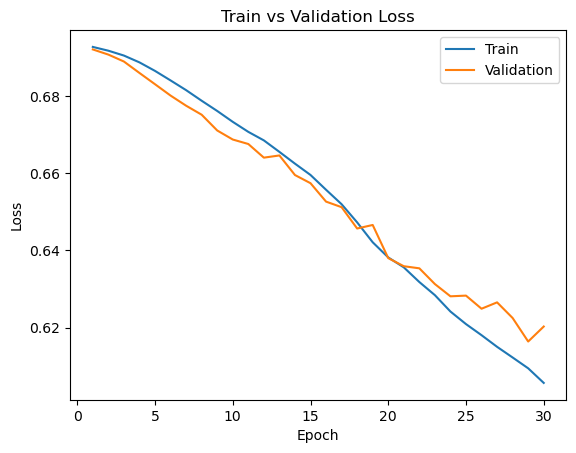

In [32]:
model_path = get_model_name("large", batch_size=40, learning_rate=0.001, epoch=29)
dir = "large_net_Optimize5"
plot_training_curve(model_path, dir)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
# The results still show underfitting as the loss remains high. I'll adjust the batch size to 256, which will encourage underfitting, but will adjust the learning rate up to 0.01, to prevent underfitting
# too much.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [11]:
large_net = LargeNet()
train_net(large_net, batch_size=256, learning_rate=0.01)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.467625, Train loss: 0.6926687732338905 |Validation err: 0.4355, Validation loss: 0.6918838396668434
Epoch 2: Train err: 0.45125, Train loss: 0.691392095759511 |Validation err: 0.446, Validation loss: 0.6896145716309547
Epoch 3: Train err: 0.4285, Train loss: 0.6892960015684366 |Validation err: 0.418, Validation loss: 0.6862078309059143
Epoch 4: Train err: 0.432625, Train loss: 0.6857281923294067 |Validation err: 0.4185, Validation loss: 0.6810973808169365
Epoch 5: Train err: 0.4265, Train loss: 0.6823585461825132 |Validation err: 0.4145, Validation loss: 0.6774221956729889
Epoch 6: Train err: 0.41825, Train loss: 0.6785925719887018 |Validation err: 0.415, Validation loss: 0.6732233017683029
Epoch 7: Train err: 0.40825, Train loss: 0.6743755359202623 |Validation err: 0.412, Validation loss: 0.6695992276072502
Epoch 8: Train err: 0.40175, Train loss: 0.6709124762564898 |Validation err: 0.401

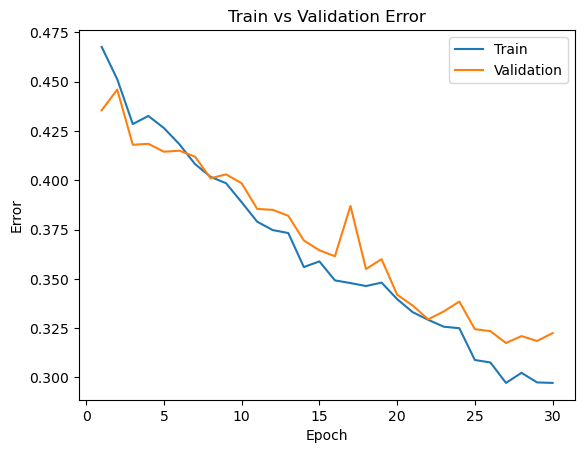

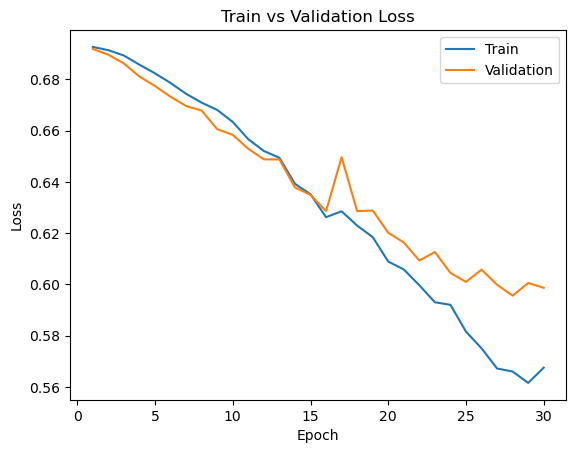

In [12]:
model_path = get_model_name("large", batch_size=256, learning_rate=0.01, epoch=29)
dir = "large_net_Optimize6"
plot_training_curve(model_path, dir)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [14]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.01, epoch=29)
model_path = "large_net_Optimize6/" + model_path
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# The large net model with a batch size of 256 and learning rate of 0.01 was chosen because it minimized our validation error and was also more efficient to train than using a smaller batch size 
# and a smaller learning rate.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [15]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

criterion = nn.BCEWithLogitsLoss() # Maintaining same loss function as used in training and validation for comparison purposes
test_err, test_loss = evaluate(net, test_loader, criterion)
test_err

Files already downloaded and verified
Files already downloaded and verified


0.3145

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# The test error was found to be 0.3145, whereas the validation error was 0.3185. I would have expected the test error to be higher than the validation error because the model is tuned using
# the validation results, whereas the test data is new input that has never been seen before. The difference in error here is essentially none, but within deviation, the test error should be higher.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# It is important to use the test data at the very end/as little as possible because it is a set of data that the model has not seen yet, making it a valuable source of determining the true
# performance of the model. Also, sometimes data is very limited, so we want to reserve the test data as much as possible to avoid the need to collect more data when conducting final testing.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [23]:
# Hyperparameters
batch_size = 256
learning_rate = 0.005
hidden_units = 20
epochs = 30

torch.manual_seed(1)

# Define an ANN class to run training loop on
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3 * 32 * 32, hidden_units) # Set input size based on 32 as the input data is divisible by this
        self.layer2 = nn.Linear(hidden_units, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32) # Flatten input image from original shape to (-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1) # Need to squeeze dim 1 to return results as the [batch size], rather than [batch_size,1]
        return activation2

ann = ANN()

# Run training loop on ANN
train_net(ann, batch_size, learning_rate, epochs)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.450625, Train loss: 0.6846347451210022 |Validation err: 0.4175, Validation loss: 0.6684708222746849
Epoch 2: Train err: 0.399375, Train loss: 0.6624630521982908 |Validation err: 0.4045, Validation loss: 0.6583033204078674
Epoch 3: Train err: 0.392375, Train loss: 0.6542007736861706 |Validation err: 0.393, Validation loss: 0.6553103402256966
Epoch 4: Train err: 0.383, Train loss: 0.6476728841662407 |Validation err: 0.3915, Validation loss: 0.6521767526865005
Epoch 5: Train err: 0.373125, Train loss: 0.6422500051558018 |Validation err: 0.387, Validation loss: 0.6495689377188683
Epoch 6: Train err: 0.370375, Train loss: 0.6388430949300528 |Validation err: 0.3885, Validation loss: 0.6489780619740486
Epoch 7: Train err: 0.365625, Train loss: 0.6347276251763105 |Validation err: 0.383, Validation loss: 0.6474003717303276
Epoch 8: Train err: 0.3575, Train loss: 0.6304521635174751 |Validation err: 

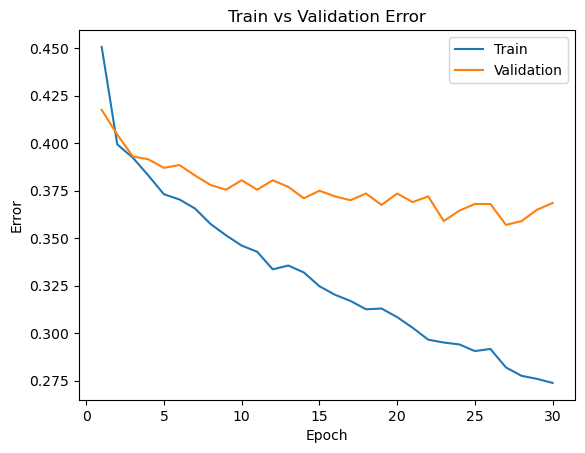

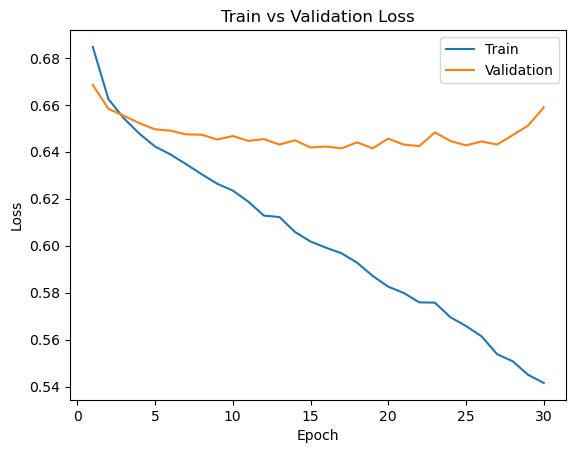

In [27]:
ANN_path = get_model_name("ANN", batch_size, learning_rate, epoch=epochs-1)
dir = "ANN_comparison"
plot_training_curve(ANN_path, dir)

In [28]:
# Evalutate ANN on test data
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=batch_size)

criterion = nn.BCEWithLogitsLoss() # Maintaining same loss function as used in training and validation for comparison purposes
test_err, test_loss = evaluate(ann, test_loader, criterion)
test_err

Files already downloaded and verified
Files already downloaded and verified


0.373

In [ ]:
# The best ANN performance I could optimize for had a test classification error of 0.373, whereas the CNN test classification error was 0.31. Clearly, the use of convolutional layers to filter the
# image data is useful in extracting key features for the image detection.